# Landsat calibration using MODIS SST
Create matchups between Landsat and MODIS SST data near Cosgrove, West Antarctica
to produce a calibration for Landsat SSTs

In [ ]:
%conda install pygmt

In [1]:
# Import libraries and modules
%config InlineBackend.figure_format = 'svg'
%matplotlib widget
import pandas as pd
import xarray as xr
import geopandas as gpd
from datetime import date, timedelta, datetime
import numpy as np
import matplotlib.pylab as plt
from matplotlib import colors
from matplotlib.pylab import rcParams
import cartopy.crs as ccrs
import cartopy

import os
from cycler import cycler
import pyproj
from pyproj import Proj, transform
from sklearn.neighbors import BallTree
import pytz
import pygmt
import gc
import copy
import random
import statsmodels.formula.api as sm
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
#For color cycling in plots that is color blind friendly...make new ones at "I want hue" tools.medialab.sciences-po.fr/iwanthue
color_cycler = cycler(color=["#6777cf","#adba49","#c65ca0","#5fa042","#683287","#72ce7b","#c44a48","#45c7a9","#933c1d","#d0803f","#ac9239","#317c39"])
colorline_cycler = (cycler(color=["#75a141","#6c61b9","#bc4d45","#c1913d","#b85298","#4aa8e8"]) +
                 cycler(linestyle=['-','--',':','-.','-','--']))
rcParams['axes.prop_cycle'] = cycler('color', color_cycler)

## Build Landsat - MODIS SST matchups

In [3]:
# Import earthaccess Library and view version
import earthaccess

In [4]:
# Set paths and important variables
sstpath = '/home/jovyan/Data/SST/MODcalib/Offshore/'
spacing = [990,-990] # 300m sampling of MODIS data so that upsampling is easy and because 30m takes far too long
param = 'sea_surface_temperature'

In [5]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 09/16/2023
Using .netrc file for EDL


In [6]:
def find_MODIS(ls_scene):
    '''
    Finds the MODIS scene most closely coincident to a Landsat scene
    
    Variables: 
    ls_scene = xarray for one Landsat scene
    
    Outputs:
    mod_scene = xarray of MODIS SST image coincident in time with the Landsat scene
    granules[ind]['umm']['GranuleUR'] = modis file name
    '''
    
    ULX = ls_scene.x[0] 
    ULY = ls_scene.y[0]  
    LRX = ls_scene.x[-1] 
    LRY = ls_scene.y[-1]
    
    # Get the existing coordinate system
    old_cs = ls_scene.rio.crs #crs[6:] # 'epsg:3031'
    new_cs = 'epsg:4326'

    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)
    
    if LRY>ULY:
        [ULX,LRX], [ULY,LRY] =  transform(inProj,outProj,[ULX,LRX], [ULY,LRY], always_xy=True)
    else:
        [ULX,LRX], [ULY,LRY] =  transform(inProj,outProj,[ULX,LRX], [LRY,ULY], always_xy=True)

    bbox = (ULX,LRY,LRX,ULY)

    # Get date/time for Landsat image and search for corresponding MODIS imagery  
    ls_time = pd.to_datetime(ls_scene.time.values)
    calc_dt = datetime.strptime(ls_time.strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
    start_dt = (calc_dt + timedelta(days=-0.5)).strftime('%Y-%m-%d %H:%M:%S')
    end_dt = (calc_dt + timedelta(days=0.5)).strftime('%Y-%m-%d %H:%M:%S')

    # Gather all files from search location from Terra and Aqua for the same day as the Landsat image
    granules = earthaccess.search_data(
        short_name='MODIS_T-JPL-L2P-v2019.0',
        bounding_box=bbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    granules2 = earthaccess.search_data(
        short_name='MODIS_A-JPL-L2P-v2019.0', #MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_NIGHTTIME_V2019.0
        bounding_box=bbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    granules = granules + granules2
    print (f'{len(granules)} TOTAL')
    
    # Find MODIS image closest in time to each Landsat image
    # make Landsat datetime timezone aware (UTC)
    Mdates = [pd.to_datetime(granule['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']) for granule in granules]
    ind = Mdates.index(min( Mdates, key=lambda x: abs(x - pytz.utc.localize(ls_time))))

    mod_scene = xr.open_dataset(earthaccess.open(granules[ind:ind+1])[0])
    mod_scene = mod_scene.rio.write_crs("epsg:4326", inplace=True)
    
    return mod_scene, granules[ind]['umm']['GranuleUR']

########################## 

def get_wv(ls_scene,mod07,spacing,param):
    '''
    ***This is copied in LandsatCalibration, modifications have been made but some may tranfer
    
    Create MODIS files aligned and subsampled to Landsat
    
    Variables:
    ls_scene = xarray dataset of a Landsat scene
    mod07 = xarray datarray with MODIS data
    spacing = list of desired spatial resolution of output data from the alignment of MODIS to Landsat in y and x (e.g.,[300,-300])
    param = string for desired dataset from MODIS file
    
    Output:
    WV_xr = xarray dataarray of Landsat aligned and upsampled modis data from desired dataset
    
    '''
    # Read in desired variables and paths
    
    uniqWV = []
    gdalstr = []

    ULX = ls_scene.x[0] 
    ULY = ls_scene.y[0]
    LRX = ls_scene.x[-1]
    LRY = ls_scene.y[-1] 
    box = [ULX,LRX,ULY,LRY]

    mod = 0
              
    # Produce indicies for aligning MODIS pixel subset to match Landsat image at 4000m (or 300)resolution
    indiciesMOD,lines,samples,x1,y1 = MODISlookup(mod07,ls_scene,box,spacing)

    # Align MODIS WV to Landsat on slightly upsampled grid
    dataOutWV,uniqImgWV = uniqueMODIS(mod07,indiciesMOD,lines,samples) # dataOut = MODIS data aligned and subset to Lsat scene

    red_y = int(abs(spacing[0]/30))
    red_x = int(abs(spacing[1]/30))
    dataOutWV_xr = xr.DataArray(dataOutWV,name='SST',dims=["y","x"], coords={"latitude": (["y"],ls_scene.y.values[::red_y]), "longitude": (["x"],ls_scene.x.values[::red_x])})

    # Resample MODIS to Landsat resolution and interpolate with B-spline
    # Output of shape fits and need to adjust x and y coords cuz are wrong
    ups_factor = 30/spacing[0]
    WV_upsample = pygmt.grdsample(grid=dataOutWV_xr, spacing=f'{ups_factor}k',interpolation='b')

    # Put into Xarray
    latnew = np.arange(dataOutWV_xr.latitude[0],dataOutWV_xr.latitude[-1]+1,(dataOutWV_xr.latitude[-1]-dataOutWV_xr.latitude[0])/(WV_upsample.shape[0]-1))
    if (WV_upsample.shape[0]!=latnew.shape[0]):
        latnew = np.arange(dataOutWV_xr.latitude[0],dataOutWV_xr.latitude[-1]+1,(dataOutWV_xr.latitude[-1]-dataOutWV_xr.latitude[0])/(WV_upsample.shape[0]))
    lonnew = np.arange(dataOutWV_xr.longitude[0],dataOutWV_xr.longitude[-1]+1,(dataOutWV_xr.longitude[-1]-dataOutWV_xr.longitude[0])/(WV_upsample.shape[1]-1))
    if (WV_upsample.shape[1]!=lonnew.shape[0]):
        lonnew = np.arange(dataOutWV_xr.longitude[0],dataOutWV_xr.longitude[-1]+1,(dataOutWV_xr.longitude[-1]-dataOutWV_xr.longitude[0])/(WV_upsample.shape[1]))
    WV_xr = xr.DataArray(WV_upsample,name='SST',dims=["y","x"], coords={"latitude": (["y"],latnew), "longitude": (["x"],lonnew)})
    WV_xr = WV_xr.rio.write_crs("epsg:3031", inplace=True)
    WV_xr = WV_xr.rename({'longitude':'x','latitude':'y'})
    WV_xr = WV_xr.set_index(x='x')
    WV_xr = WV_xr.set_index(y='y')

    #Append WV values
    uniqWV.append(uniqImgWV)
    mod = 1 
    
    try:
        # Min and max MODIS values for a scene
        maxi =[]
        mini =[]
        for m in uniqWV:
            maxi.append(max(m))
            mini.append(min(m))

        print (f'Max {param}: {np.max(maxi)}, min: {np.min(mini)}')
    except:
        print (f'Max {param}: {np.nan}, min: {np.nan}')
    
    return WV_xr
           
##########################           

def MODISlookup (mod07,lsat_filt_msk,box,spacing):
    '''
    Look up atmospheric consituents from MODIS product for each Landsat pixel
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file 
    # and Shane Grigsby

    Variables:    
    mod07 = xarray with MODIS data with crs 4326 assigned
    lsat_filt_msk =  Landsat xarray DataArray
    box = list with [left easting,right easting,top northing,bottom northing]
    spacing = desired pixel size for extraction, list of [east/west, north/south] 
          (recommend choosing a number that allows for fast calculations and even division by 30)

    Output:
    indiciesMOD = indicies used to project MODIS pixels to match Landsat pixels
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    x1,y1 = x and y coordinates for grid
    '''
    
    lat, lon = mod07.lat, mod07.lon # Different for SST vs WV

    # Get the existing coordinate system
    old_cs = ls_scene.rio.crs #crs[6:] # 'epsg:3031'
    new_cs = mod07.rio.crs #'epsg:4326'

    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)

    # Parse coordinates and spacing to different variables
    west = box[0]
    east = box[1]
    north = box[2]
    south = box[3]
    ewspace = spacing[0]
    nsspace = spacing[1]

    # Setting up grid, x coord from here to here at this spacing, mesh grid makes 2D
    samples = len(np.r_[west:east+1:ewspace])
    lines = len(np.r_[north:south-1:nsspace])#ns space is -300, could also do 30 instead of 300, but would just have duplicate pixels
    if lines==0:
        lines = len(np.r_[south:north-1:nsspace])
        
    # x1, y1 = np.meshgrid(np.r_[west:east:ewspace],np.r_[north:south:nsspace]) # offset by 1 meter to preserve shape
    ewdnsamp = int(spacing[0]/30)
    nsdnsamp = int(spacing[1]/30)
    x1, y1 = np.meshgrid(ls_scene.x.values[::ewdnsamp],ls_scene.y.values[::nsdnsamp])
    LScoords = np.vstack([x1.ravel(),y1.ravel()]).T

    # Ravel so ND can lookup easily
    # Convert from map coords to lat lon --> x = lon, y = lat
    xs, ys =  transform(inProj,outProj,LScoords[:,0], LScoords[:,1], radians=True, always_xy=True)
    grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T # note y / x switch (i.e., lat long convention)
    
    if len(grid_coords) != lines*samples:
        return print (f'Size of grid coordinates do not match low resolution Landsat dims: {len(grid_coords)} vs. {lines*samples}')
    MODIS_coords = np.vstack([lat.values.ravel(),lon.values.ravel()]).T
    MODIS_coords *= np.pi / 180. # to radians
    
    # Build lookup, haversine = calc dist between lat,lon pairs so can do nearest neighbor on sphere - if did utm it would be planar
    MOD_Ball = BallTree(MODIS_coords,metric='haversine') #sklearn library
    #LS_Ball = BallTree(grid_coords,metric='haversine') # In case want reverse coordinate for Landsat
    # Query modis coords with landsat coords, gives distance between and index for nearest neighbor
    distanceMOD, indiciesMOD= MOD_Ball.query(grid_coords, dualtree=True, breadth_first=True)
        
    return indiciesMOD,lines,samples,x1,y1

##########################

def uniqueMODIS(mod07,indiciesMOD,lines,samples):
    '''
    Extracts data values and unique values from desired MODIS dataset that corresponds to Landsat file
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    
    Variables: 
    mod07 = xarray with MODIS data with crs 4326 assigned    
    indiciesMOD = indicies output for neighest neighbor query from MODIS to Landsat coordinates
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    
    Output:
    dataOut = MODIS atm image subset and aligned to Landsat image pixels
    uniq = uniq MODIS atm values within area of Landsat image
    #counts = count for each unique value in subset
    '''

    #Extract desired datasets from MODIS file from lookup key
    data = mod07[0,:,:]
    lat, lon = mod07.lat, mod07.lon
    #data.attributes()

    if (np.shape(lat)== np.shape(lon)== np.shape(data))==False:
        print ("Error in creating indicies, lat/lon and data shapes do not match")

    # Reproject data from MODIS into corresponding postions for Landsat pixels for the desired dataset
    if param == 'sea_surface_temperature':
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD],(lines,samples))-273.15#* # to scale?
        dataOut[dataOut < -3] = np.nan
        # MODimg = np.array(data.values)#* # to scale?
        # MODimg[MODimg < 0] = np.nan
    if param == 'Water_Vapor':
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD]*0.0010000000474974513,(lines,samples))
        dataOut[dataOut < 0] = np.nan
        MODimg = np.array(data.values*0.001000000047497451)
        MODimg[MODimg < 0] = np.nan
    if param == 'Total_Ozone':
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD]*0.10000000149011612,(lines,samples))
        dataOut[dataOut < 225] = np.nan
        dataOut[dataOut > 430] = np.nan
        MODimg = np.array(data.values*0.10000000149011612)
        MODimg[MODimg < 0] = np.nan

    # Get unique values for datasets within Landsat extent
    #uniq, inverse, counts= np.unique(dataOut, return_inverse=True, return_counts=True)
    uniq = set(dataOut[np.isfinite(dataOut)])
    return dataOut,uniq # Can also output MODimg and inverse and counts if desired

##########################

# Preprocess to add time dimension to open_mfdataset for landsat using the filename
def add_time_dim(ds):
    lstr = ds.encoding["source"].split("LC0",1)[1]
    times = pd.to_datetime(lstr[14:22]+lstr[38:44], format='%Y%m%d%H%M%S')
    return ds.assign(time=times)

In [23]:
# Get Landsat file paths in directory
lsatfiles = os.listdir(sstpath)
lsatfiles = [x for x in lsatfiles if x[-3:] == 'tif']
print (len(lsatfiles))

os.chdir('/home/jovyan/Data/SST/MODcalib/Offshore')

# Concatenate all landsat files into xarray with a time dimension
ls_scenes = xr.open_mfdataset(lsatfiles,chunks=dict(x=512, y=512),combine='nested',preprocess=add_time_dim,concat_dim="time",engine='rasterio')

41


In [10]:
# Calibration region bounding box
# latboundsC = [ -73.5 , -73.42 ] # near Cosgrove
# lonboundsC = [ -103.0 , -102.0 ]

latboundsC = [ -69.9, -69.6 ] # Offshore NE Amundsen
lonboundsC = [ -99.2 , -98.4 ]

In [11]:
# Convert bounding box to polar for checking if landsat has any data in bounding box
# Speeds up process a lot
source_crs = 'epsg:4326' 
target_crs = 'epsg:3031' # Coordinate system of the file

topolar = pyproj.Transformer.from_crs(source_crs,target_crs)
polarx,polary = topolar.transform([latboundsC[1],latboundsC[0]],[lonboundsC[0],lonboundsC[1]])

In [24]:
ls_scenes = ls_scenes.sel(time='2014-01-14')

In [25]:
%%time
# ~2 min 25 sec per image
# If number of MODIS images per satellite is much more than 25, there is a ULY,LRY issue

lsat_mod = []

# For each processed Landsat SST image in this region
for timeidx in range(ls_scenes.time.shape[0]):
    
    # Open into xarray and assign proper epsg and datetime
    ls_scene = ls_scenes.isel(time=timeidx)
    ls_scene = ls_scene.assign_attrs({"ID": lsatfiles[timeidx]})
    print (ls_scene.ID)
    
    ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)
    
    # Crop Landsat to region and take mean temp,  
    # will skip the modis stage if no Landsat data in the calibration region
    try:
        ls_sub = ls_scene.sel(band=1,y=slice(polary[0],polary[1]),x=slice(polarx[0],polarx[1])).to_array()
        # Check for right dimensions because y order changes sometimes
        if (ls_sub.shape[1]>0)&(ls_sub.shape[2]>0):
            # lsat = np.nanmean(ls_reproj.sel(y=slice(latboundsC[1],latboundsC[0]),x=slice(lonboundsC[0],lonboundsC[1])).to_array())
            lsat = np.nanmean(ls_sub)
        elif ls_sub.shape[1]==0:
            print ('L8 y shape is 0')
            ls_sub = ls_scene.sel(band=1,y=slice(polary[1],polary[0]),x=slice(polarx[0],polarx[1])).to_array()
            lsat = np.nanmean(ls_sub)
        elif ls_sub.shape[2]==0:
            print ('L8 x shape is 0')
            ls_sub = ls_scene.sel(band=1,y=slice(polary[0],polary[1]),x=slice(polarx[1],polarx[0])).to_array()
            lsat = np.nanmean(ls_sub)
    except Exception as e:
        print (ls_scene.ID, e)
        lsat = np.nan
    
    print(lsat)
    if ~np.isfinite(lsat):
        continue
    
    # Find coincident MODIS SST scene
    mod_scene, mod_file = find_MODIS(ls_scene)
    print(mod_file)
    
    try:
        # Acquire and align MODIS data to Landsat ***this takes a while
        MODsst_xr = get_wv(ls_scene,mod_scene.sea_surface_temperature,spacing,param)
        
        # # Reproject both to WGS84 - it might be better to crop in 3031 - x,y dimensions change with reprojection so maybe answers are changing...
        # ls_reproj = ls_scene.rio.reproject("EPSG:4326")
        # mod_reproj = MODsst_xr.rio.reproject("EPSG:4326")

        # Crop to region and take mean temp, not sure why 0 (MOD09) vs -1 (GHRSST) work here
        # modis = np.nanmean(mod_reproj.sel(y=slice(latboundsC[1],latboundsC[0]),x=slice(lonboundsC[0],lonboundsC[1])))
        MODsst_xr_sub = MODsst_xr.sel(y=slice(polary[0],polary[1]),x=slice(polarx[0],polarx[1]))
        if (MODsst_xr_sub.shape[0]>0)&(MODsst_xr_sub.shape[1]>0):
            # lsat = np.nanmean(ls_reproj.sel(y=slice(latboundsC[1],latboundsC[0]),x=slice(lonboundsC[0],lonboundsC[1])).to_array())
            modis = np.nanmean(MODsst_xr_sub)
        elif MODsst_xr_sub.shape[0]==0:
            print ('MOD y shape is 0')
            MODsst_xr_sub = MODsst_xr.sel(y=slice(polary[1],polary[0]),x=slice(polarx[0],polarx[1]))
            modis = np.nanmean(MODsst_xr_sub)
        elif ls_sub.shape[1]==0:
            print ('MOD x shape is 0')
            MODsst_xr_sub = MODsst_xr.sel(y=slice(polary[0],polary[1]),x=slice(polarx[1],polarx[0]))
            modis = np.nanmean(MODsst_xr_sub)
        print (MODsst_xr_sub.shape)
        
    except Exception as e:
        print (mod_file, e)
        modis = np.nan
        
    # Append file names with SST means from the Cosgrove box
    lsat_mod.append([mod_file,modis,ls_scene.ID,lsat])
    print (f'MODIS mean: {modis}, Landsat 8: {lsat}')
    
    # try:
    #     del ls_scene, ls_sub, mod_scene, MODsst_xr, MODsst_xr_sub
    # except:
    #     pass
        
    gc.collect()

LC08_L1GT_003109_20190128_20201016_02_T2_150222_Cel.tif
nan
LC08_L1GT_005109_20190126_20201016_02_T2_151445_Cel.tif
nan
CPU times: user 11.9 s, sys: 1.24 s, total: 13.2 s
Wall time: 12.9 s


In [15]:
# # Put data into DataFrame and save    
# headers = ['MODIS_filename','MODIS_SST','L8_filename','L8_SST']
# lsat_mod_df = pd.DataFrame(lsat_mod,columns=headers)
# out_df = '/home/jovyan/Data/MODISvLandsat_Offshore_20230629'
# lsat_mod_df.to_pickle(out_df)

In [ ]:
ls_scene.rio.reproject("EPSG:4326")

In [ ]:
MODsst_xr.rio.reproject("EPSG:4326")

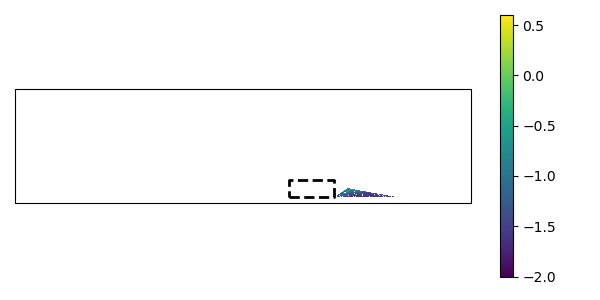

In [28]:
# Plot Landsat SST example
ls_reproj = ls_scene.rio.reproject("EPSG:4326")
# lsdt = ls_reproj.sel(band=1,y=slice(-73.3,-73.6),x=slice(-105,-100)).band_data
lsdt = ls_reproj.sel(band=1,y=slice(-69.6,-69.9),x=slice(-103,-97)).band_data

plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
cb = ax.pcolormesh(lsdt.x,lsdt.y,lsdt,vmin=-2.0,vmax=0.6,transform=ccrs.PlateCarree())
plt.plot([-99.2,-98.4,-98.4,-99.2,-99.2],[-69.9,-69.9,-69.6,-69.6,-69.9],lw=2,ls='--',color='k',transform=ccrs.PlateCarree())
ax.set_ylim([-70 , -68])
ax.set_xlim([-104,-96])
# plt.plot([-103.0,-102.0,-102.0,-103.0,-103.0],[-73.5,-73.5,-73.42,-73.42,-73.5],lw=2,ls='--',color='k',transform=ccrs.PlateCarree())
# ax.set_ylim([-73.8 , -73.1])
# ax.set_xlim([-103.9,-101.5])
cbar = plt.colorbar(cb)
plt.tight_layout()

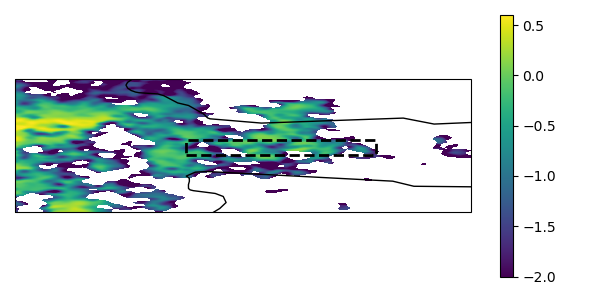

In [117]:
# Plot MODIS SST example
# dataOutWV_xr = dataOutWV_xr.rename({"latitude":'y', 'longitude':'x'})
# dataOutWV_xr = dataOutWV_xr.rio.write_crs("epsg:3031", inplace=True)
# mod_reproj = MODsst_xr.rio.reproject("EPSG:4326")

# moddt = mod_reproj.sel(y=slice(-69.6,-69.9),x=slice(-103,-97))

plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
# cb = ax.pcolormesh(dataOutWV_xr.longitude,dataOutWV_xr.latitude,dataOutWV_xr,vmin=-2.0,vmax=0.6,transform=cartopy.crs.epsg(3031))
cb = ax.pcolormesh(mod_reproj.x,mod_reproj.y,mod_reproj,vmin=-2.0,vmax=0.6,transform=ccrs.PlateCarree())
# cb = ax.pcolormesh(mod07.lon,mod07.lat,mod07[0,:,:],vmin=-2.0,vmax=15,transform=ccrs.PlateCarree())
# plt.plot([-99.2,-98.4,-98.4,-99.2,-99.2],[-69.9,-69.9,-69.6,-69.6,-69.9],lw=2,ls='--',color='k',transform=ccrs.PlateCarree())
plt.plot([-103.0,-102.0,-102.0,-103.0,-103.0],[-73.5,-73.5,-73.42,-73.42,-73.5],lw=2,ls='--',color='k',transform=ccrs.PlateCarree())
# ax.set_ylim([-70 , -68])
# ax.set_xlim([-104,-96])
ax.set_ylim([-73.8 , -73.1])
ax.set_xlim([-103.9,-101.5])
cbar = plt.colorbar(cb)
plt.tight_layout()

In [35]:
# # Plot MODIS SST example - Cosgrove
# mod_reproj = MODsst_xr.rio.reproject("EPSG:4326")

# moddt = mod_reproj.sel(y=slice(-73.3,-73.6),x=slice(-105,-100))

# plt.figure(figsize=(6, 3))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# ax.coastlines()
# cb = ax.pcolormesh(moddt.x,moddt.y,moddt,vmin=-2.0,vmax=0.6,transform=ccrs.PlateCarree())
# plt.plot([-103.0,-102.0,-102.0,-103.0,-103.0],[-73.5,-73.5,-73.42,-73.42,-73.5],lw=2,ls='--',color='k',transform=ccrs.PlateCarree())
# ax.set_ylim([-73.8 , -73.1])
# ax.set_xlim([-103.9,-101.5])
# cbar = plt.colorbar(cb)
# plt.tight_layout()

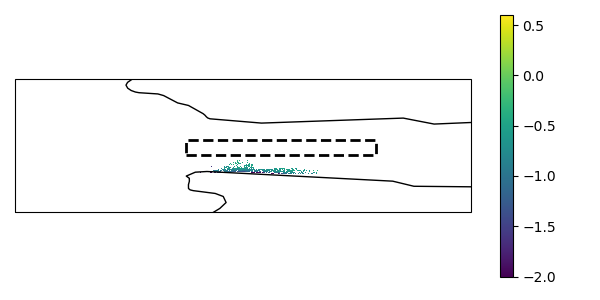

In [93]:
# # Plot Landsat SST example
# ls_reproj = ls_scene.rio.reproject("EPSG:4326")
# lsdt = ls_reproj.sel(band=1,y=slice(-73.3,-73.6),x=slice(-105,-100)).band_data

# plt.figure(figsize=(6, 3))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# ax.coastlines()
# cb = ax.pcolormesh(lsdt.x,lsdt.y,lsdt,vmin=-2.0,vmax=0.6,transform=ccrs.PlateCarree())
# plt.plot([-103.0,-102.0,-102.0,-103.0,-103.0],[-73.5,-73.5,-73.42,-73.42,-73.5],lw=2,ls='--',color='k',transform=ccrs.PlateCarree())
# ax.set_ylim([-73.8 , -73.1])
# ax.set_xlim([-103.9,-101.5])
# cbar = plt.colorbar(cb)
# # cbar.set_clim(-1, -6) # set limits of color map
# plt.tight_layout()

## Calculate calibration bias and trend
Uses a [RANSAC regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html), but provides comparisons to an Ordinary Least Squares regression calculation from statsmodel of the same parameters.

In [7]:
# Read in paired MODIS/Landsat data created above

# From the Cosgrove area
# # 2019-2021 data ***no 2021 data
# out_df = '/home/jovyan/Data/MODISvLandsat_Cosgrove_20230622'
# df3 = pd.read_pickle(out_df)
# # 2017,2018,2022 data
# out_df = '/home/jovyan/Data/MODISvLandsat_Cosgrove_20230622_2'
# df4 = pd.read_pickle(out_df)
# # 2014-2016 data
# out_df = '/home/jovyan/Data/MODISvLandsat_Cosgrove_20230626'
# df5 = pd.read_pickle(out_df)
# # 2023 data
# out_df = '/home/jovyan/Data/MODISvLandsat_Cosgrove_20230627'
# df6 = pd.read_pickle(out_df)
# lsat_mod_df_n = pd.concat([df3,df4,df5,df6])

# out_df = '/home/jovyan/Data/MODISvLandsat_Cosgrove_20230628'
# df1 = pd.read_pickle(out_df)
# out_df = '/home/jovyan/Data/MODISvLandsat_Cosgrove_20230628_2'
# df2 = pd.read_pickle(out_df)
# out_df = '/home/jovyan/Data/MODISvLandsat_Cosgrove_20230629'
# df3 = pd.read_pickle(out_df)
# lsat_mod_df_n = pd.concat([df1,df2,df3])

# For offshore NE Amundsen Sea region
out_df = '/home/jovyan/Data/MODISvLandsat_Offshore_20230629'
df1 = pd.read_pickle(out_df)
lsat_mod_df_n = df1

In [8]:
# Ordinary least squares regression between Landsat and MODIS SST matchups
resultC = sm.ols(formula="L8_SST ~ MODIS_SST", data=lsat_mod_df_n).fit()
print (resultC.summary())

ValueError: zero-size array to reduction operation maximum which has no identity

In [15]:
# Ordinary least squares regression between Landsat and MODIS SST matchups
resultC = sm.ols(formula="L8_SST ~ MODIS_SST", data=lsat_mod_df_n).fit()
print (resultC.summary())

                            OLS Regression Results                            
Dep. Variable:                 L8_SST   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     26.66
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           0.000144
Time:                        15:53:25   Log-Likelihood:                -15.292
No. Observations:                  16   AIC:                             34.58
Df Residuals:                      14   BIC:                             36.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8675      0.184     -4.718      0.0

In [19]:
# Ordinary least squares regression between Landsat and MODIS SST matchups
resultC = sm.ols(formula="L8_SST ~ MODIS_SST", data=lsat_mod_df_n).fit()
print (resultC.summary())

                            OLS Regression Results                            
Dep. Variable:                 L8_SST   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     31.67
Date:                Tue, 27 Jun 2023   Prob (F-statistic):           6.23e-05
Time:                        16:55:52   Log-Likelihood:                -14.362
No. Observations:                  16   AIC:                             32.72
Df Residuals:                      14   BIC:                             34.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8770      0.172     -5.097      0.0

In [16]:
# RANSAC Regression for atm corrected SST
xdata = 'MODIS_SST'
ydata = 'L8_SST'
forrsac = lsat_mod_df_n[[xdata,ydata]].dropna()
xC = np.reshape(forrsac[xdata].values,(forrsac[xdata].shape[0],1))
yC = np.reshape(forrsac[ydata].values,(forrsac[ydata].shape[0],1))
reg = RANSACRegressor(random_state=0).fit(xC,yC)
yLC = reg.predict(xC)
scoreC = reg.score(xC,yC)

lreg = LinearRegression().fit(xC,yLC)
print ('m = '+str(lreg.coef_[0][0]))
print ('b = '+str(lreg.intercept_[0]))
print ('score = '+str(scoreC))

m = 0.8800909167159475
b = -0.7286767494488193
score = 0.6302192478915731


In [46]:
# Permuation test for p-value pearson or RANSAC
# https://towardsdatascience.com/how-to-assess-statistical-significance-in-your-data-with-permutation-tests-8bb925b2113d

# Initialize variables
pR = []
x = xC
y = yC
# Choose number of permutations
p=10000
#I nitialize permutation loop
for i in range(0,p):
    # Shuffle one of the features
    pS = copy.copy(y)
    random.shuffle(pS)
    # Computed permuted correlations and store them in pR
    reg = RANSACRegressor(random_state=0).fit(x,pS)
    pR.append(reg.score(x,pS))
#     pR.append(stats.pearsonr(xC,yLC)[0])

# Significance
p_val = len(np.where(np.abs(pR)>=np.abs(scoreC))[0])/np.float(p)
print (p_val)

0.083


In [13]:
print (lreg.coef_[0])
print (lreg.intercept_[0])

[0.7642797]
-1.1611010761556393


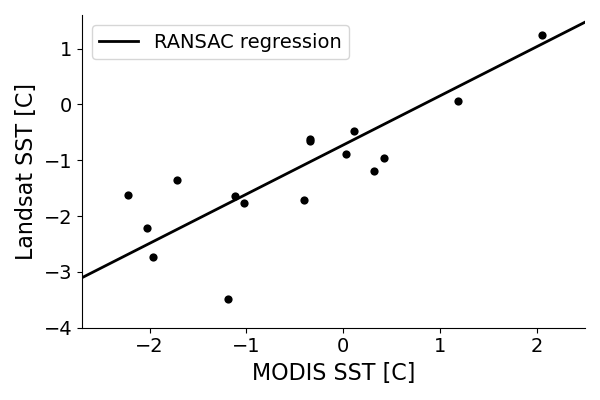

In [17]:
# Plot data points and RANSAC regression
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(6, 4))
xi = np.arange(-7.0,5.0,1.0)

data = lsat_mod_df_n

a1 = ax
a1.tick_params(labelsize=14)
a1.scatter(data[xdata],data[ydata],color='k',linewidth=0,s=35,label='_no label_')
a1.plot(xi,xi*lreg.coef_[0]+lreg.intercept_[0],color='k',linewidth=2,label='RANSAC regression')
# a1.text(-2,-1.7,'y=0.34x+0.38 acc=0.5',fontsize=14)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
a1.set_ylim([-4,1.6])
a1.set_xlim([-2.7,2.5])
a1.set_xlabel('MODIS SST [C]',fontsize=16)
a1.set_ylabel('Landsat SST [C]',fontsize=16)
a1.legend(markerscale=1,fontsize=14,loc='upper left')

plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Manuscripts/AmundsenCC_Manuscript/Figures/LMCalibration.jpg', format='jpg', dpi=1000)
plt.show()

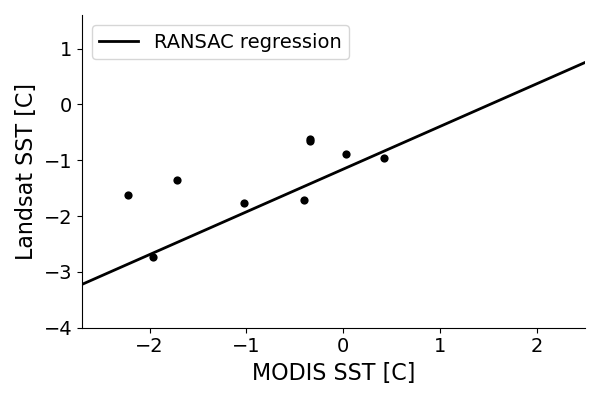

In [14]:
# Plot data points and RANSAC regression
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(6, 4))
xi = np.arange(-7.0,5.0,1.0)

data = lsat_mod_df_n

a1 = ax
a1.tick_params(labelsize=14)
a1.scatter(data[xdata],data[ydata],color='k',linewidth=0,s=35,label='_no label_')
a1.plot(xi,xi*lreg.coef_[0]+lreg.intercept_[0],color='k',linewidth=2,label='RANSAC regression')
# a1.text(-2,-1.7,'y=0.34x+0.38 acc=0.5',fontsize=14)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
a1.set_ylim([-4,1.6])
a1.set_xlim([-2.7,2.5])
a1.set_xlabel('MODIS SST [C]',fontsize=16)
a1.set_ylabel('Landsat SST [C]',fontsize=16)
a1.legend(markerscale=1,fontsize=14,loc='upper left')

plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Manuscripts/AmundsenCC_Manuscript/Figures/LMCalibration.jpg', format='jpg', dpi=1000)
plt.show()

## Test to see if rioxarray reproject is causing issues

I noticed when I use rioxarray to reproject MODIS and Landsat to WGS84 (espg 4326)
that the x,y dimensions changed, which shouldn't happen. We need to keep the 
same spatial resolution and therefore dimensions. 

Here, I'm comparing the outputs of the Landsat/MODIS pair data from the method above where I immediately take the aggregate (without reprojection from espg 3031) and take the aggregate after I reproject to WGS84.

In [24]:
# Read in paired MODIS/Landsat data created above
out_df = '/home/jovyan/Data/MODISvLandsat_Cosgrove_20230621_reproj'
df1 = pd.read_pickle(out_df)
out_df = '/home/jovyan/Data/MODISvLandsat_Cosgrove_20230622_reproj'
df2 = pd.read_pickle(out_df)

df0 = pd.concat([df1,df2])

# Reran the first two, to check value differences after removing the reprojection step
out_df = '/home/jovyan/Data/MODISvLandsat_Cosgrove_20230622'
df3 = pd.read_pickle(out_df)

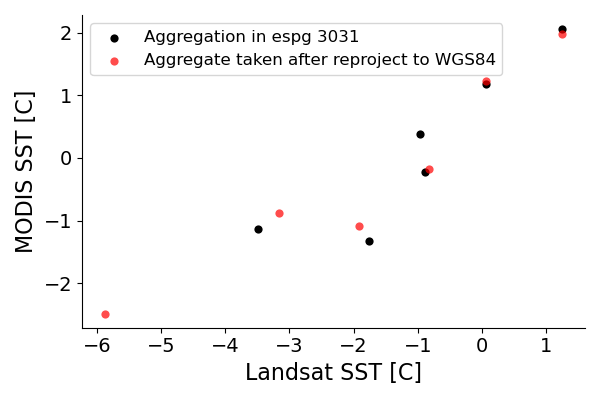

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(6, 4))
xi = np.arange(-6.0,2.0,1.0)

data = df3  # Data all aggregated in espg 3031
data0 = df0  # Half of data is aggregated after reprojecting to espg 4236

a1 = ax
a1.tick_params(labelsize=14)
a1.scatter(data[Ldata],data[Mdata],color='k',linewidth=0,s=35,label='Aggregation in espg 3031') #'_no label_')
a1.scatter(data0[Ldata],data0[Mdata],color='r',linewidth=0,s=35,alpha=0.7,label='Aggregate taken after reproject to WGS84')
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
# a1.set_xlim([-5,1.5])
# a1.set_ylim([-1.8,2.0])
a1.set_ylabel('MODIS SST [C]',fontsize=16)
a1.set_xlabel('Landsat SST [C]',fontsize=16)
a1.legend(markerscale=1,fontsize=12,loc='upper left')

plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Manuscripts/AmundsenCC_Manuscript/Figures/LMCalibration.jpg', format='jpg', dpi=1000)
plt.show()

These points don't match up, so we need to worry about using rioxarray for reprojections...

## Unused code

In [9]:
# Simple boundary boxes for Cosgrove, Trough/Central, PIG, not used at the moment
latboundsC = [ -73.5 , -73.42 ]
lonboundsC = [ -103.0 , -102.0 ]
latboundsT = [ -73.6 , -73.4 ]
lonboundsT = [ -105.0 , -104.4 ]
latboundsP = [ -74.9 , -74.75 ]
lonboundsP = [ -103.1 , -102.2 ]

-106.7,-74.42,-105.7,-74.12 -pig

-104.08,-73.59, -103.5, -73.3 -outside cosgrove

-113-3, -72.52, -112.1, -73.88 -Dotson

-99.2,-69.921,-98.4, -69.7 - off shelf Amundsen

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1180b7b90>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1224eca50> created
DEBUG:rasterio._env:GDAL_DATA found in environment: u'/usr/local/lib/python2.7/site-packages/fiona/gdal_data'.
DEBUG:rasterio._env:PROJ data files are available at built-in paths
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1224eca50>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1180b7b90>
DEBUG:rasterio._base:Sharing flag: 0
DEBUG:rasterio._base:Nodata success: 1, Nodata value: nan
DEBUG:rasterio._base:Dataset <open DatasetReader name='/Volumes/LaCieHulkedOut/SST_Thwaites/L8/LC08_L1GT_001113_20131012_20170429_01_T2/LC08_L1GT_001113_20131012_20170429_01_T2_Cel_atm.tif' mode='r'> is started.
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1180b7b90>
DEBUG

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(6, 4))
xi = np.arange(-6.0,2.0,1.0)

data = df3  # Data all aggregated in espg 3031
data2 = df0  # Half of data is aggregated after reprojecting to espg 4236

a1 = ax
a1.tick_params(labelsize=14)
a1.scatter(data[Ldata],data[Mdata],color='k',linewidth=0,s=35,label='Aggregation in espg 3031') #'_no label_')
a1.scatter(data2[Ldata],data2[Mdata],color='r',linewidth=0,s=35,alpha=0.7,label='Aggregate taken after reproject to WGS84')
# a1.scatter(MLdf['LTTemp'],MLdf['MTMean'],color='C3',linewidth=0,s=35,label='Central')
# a1.scatter(MLdf['LPTemp'],MLdf['MPMean'],color='b',linewidth=0,s=35,label='PIG')
a1.plot(xi,xi*lreg.coef_[0]+lreg.intercept_[0],color='k',linewidth=2,label='RANSAC regression')
# a1.plot(xi,xi*resultC.params[1]+resultC.params[0],color='0.6',linewidth=1.5,label='Linear regression')
a1.text(-2,-1.7,'y=0.34x+0.38 acc=0.5',fontsize=14)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)
# a1.set_xlim([-5,1.5])
# a1.set_ylim([-1.8,2.0])
a1.set_ylabel('MODIS SST [C]',fontsize=16)
a1.set_xlabel('Landsat SST [C]',fontsize=16)
a1.legend(markerscale=1,fontsize=12,loc='upper left')

# a2 = ax[1]
# a2.tick_params(labelsize=14)
# a2.scatter(MLdf['LCTemp_unc'],MLdf['MCMean'],color='k',linewidth=0,s=35,label='_no label_')
# # a2.scatter(MLdf['LTTemp_unc'],MLdf['MTMean'],color='C3',linewidth=0,s=35,label='Central')
# # a2.scatter(MLdf['LPTemp_unc'],MLdf['MPMean'],color='b',linewidth=0,s=35,label='PIG')
# a2.plot(xi,xi*lregu.coef_[0]+lregu.intercept_[0],color='k',linewidth=2,label='_no label_')
# a2.plot(xi,xi*resultCu.params[1]+resultCu.params[0],color='0.6',linewidth=1.5,label='_no label_')
# a2.spines['top'].set_visible(False)
# a2.spines['right'].set_visible(False)
# a2.set_xlim([-5,1.5])
# a2.set_xlabel('Landsat SST [C]',fontsize=16)

plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Manuscripts/AmundsenCC_Manuscript/Figures/LMCalibration.jpg', format='jpg', dpi=1000)
plt.show()